<center><h1>Convolutional Neural Networks (CNN)</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

If you find a mistake, or know how to improve this notebook, please open an issue [here](https://github.com/arthurdouillard/deepcourse/issues).

In [ ]:
%pylab inline

In [ ]:
import time

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

Define a modified [LeNet](http://yann.lecun.com/exdb/lenet/) architecture likewise:

- conv 32 output channels with 5x5 kernel +  relu
- max pooling with 2x2 kernel
- conv 64 output channels with 5x5 kernel + relu
- max pooling with 2x2 kernel
- conv 64 output channels with 5x5 kernel + relu
- max pooling with 2x2 kernel
- fully connected with 1000 output neurons + relu
- fully connected with 10 output neurons

Note that we want to preserve the spatial dimension after each convolution. Thus choose carefully the padding and stride values!

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    # TODO

  def forward(self, x):
    # TODO
    return x


net = CNN()
print(net)

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/cnn/lenet.py
%pycat lenet.py

Quick test that a forward works well, better testing right now than later with more code around:

In [ ]:
logits = net(torch.randn(2, 3, 32, 32))
print(f"Logits shape: {logits.shape}")

In [ ]:
cifar_mean = torch.tensor([0.5071, 0.4867, 0.4408])
cifar_std = torch.tensor([0.2675, 0.2565, 0.2761])

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),                            
])


train_dataset = CIFAR10("/temp", download=True, train=True, transform=train_transforms)
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, 
    [int(0.8 * len(train_dataset)), int(0.2 * len(train_dataset))]
  )
val_dataset.transform = test_transforms
test_dataset = CIFAR10("/temp", download=False, train=False, transform=test_transforms)

print(f"Nb images in train: {len(train_dataset)}")
print(f"Nb images in val: {len(val_dataset)}")
print(f"Nb images in test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=512, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=512, num_workers=2)

print(f"\nNb batches in train: {len(train_loader)}")
print(f"Nb batches in val: {len(val_loader)}")
print(f"Nb batches in test: {len(test_loader)}")

In [ ]:
x, y = next(iter(train_loader))
print(x.shape, y.shape)
print(x.min(), x.max())
print(y[:10])

classes = [
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

plt.figure(figsize=(13, 10))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  img = x[i]
  img = img * cifar_std[:, None, None] + cifar_mean[:, None, None]  # Denormalize
  img = img.permute(1, 2, 0)  # move channel at last dimension
  img = np.clip(255 * img.numpy(), a_min=0, a_max=255).astype(np.uint8)
  img = Image.fromarray(img)
  plt.imshow(img)
  plt.axis('off')
  plt.title(classes[y[i]])

In [ ]:
def eval_model(net, loader, loss_fn):
  net.eval()
  acc, loss = 0., 0.
  c = 0
  for x, y in loader:
    with torch.no_grad():
      # No need to compute gradient here thus we avoid storing intermediary activations
      logits = net(x.to(device)).cpu()

    loss += loss_fn(logits, y).item()
    preds = logits.argmax(dim=1)
    acc += (preds.numpy() == y.numpy()).sum()
    c += len(x)

  acc /= c
  loss /= len(loader)
  net.train()
  return acc, loss

Let's launch the model. Each epoch should take around 10s, if it's much longer, check that you are currently using a GPU from the menu *Runtime -> Change runtime type*.

In [ ]:
net = CNN().to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.1)#, momentum=0.9, nesterov=True)
cross_entropy = nn.CrossEntropyLoss()  # Does softmax+CE

nb_epochs = 20

train_accs, train_losses = [], []
val_accs, val_losses = [], []

initial_acc, initial_loss = eval_model(net, val_loader, cross_entropy)
print(f"Initial accuracy/loss on val: {round(100 * initial_acc, 2)}/{round(initial_loss, 4)}")

for epoch in range(nb_epochs):
  start = time.time()
  running_acc, running_loss = 0., 0.
  c = 0
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)

    optimizer.zero_grad()  # Clear previous gradients
    logits = net(x)
    loss = cross_entropy(logits, y)
    loss.backward()  # Compute gradients
    optimizer.step()  # Update weights with gradients

    running_acc += (logits.argmax(dim=1).cpu().numpy() == y.cpu().numpy()).sum()
    running_loss += loss.item()
    c += len(x)

  train_acc, train_loss = running_acc / c, running_loss / len(train_loader)
  train_accs.append(train_acc)
  train_losses.append(train_loss)
  
  val_acc, val_loss = eval_model(net, val_loader, cross_entropy)
  val_accs.append(val_acc)
  val_losses.append(val_loss)

  print(
      f"Epoch {epoch + 1}/{nb_epochs}, "
      f"train acc/loss: {round(100 * train_acc, 2)}/{round(train_loss, 4)}, "
      f"val acc/loss: {round(100 * val_acc, 2)}/{round(val_loss, 4)}, "
      f"time {int(time.time() - start)}s"
  )

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(list(range(nb_epochs)), train_accs, label="Train")
plt.plot(list(range(nb_epochs)), val_accs, label="Val")
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(list(range(nb_epochs)), train_losses, label="Train")
plt.plot(list(range(nb_epochs)), val_losses, label="Val")
plt.title("Loss")

Now that our model has trained, let's check the final test performance:

In [ ]:
test_acc, test_loss = eval_model(net, test_loader, cross_entropy)
test_acc, test_loss

Some questions for you:

- The initial accuracy and loss are around respectively 10% and 2.3. Why?
- After the first epoch, the validation accuracy is probably better than the train accuracy. Why?
- Compare the model performance on the different subsets train/val/test. What can you say?

Now, as a machine learning engineer, your job is to improve this bad model. Try each improvements one after the other in order to see where the gain come from.

Your task is to implement:
- Better **data augmentation** (mirror flip, random crop, color jittering, etc.)
- Regularization like **dropout** or **weight decay**
- Better architecture with **Batch Normalization**
- Better **optimizer** with different learning rates, with (nesterov or not) momentum, adaptive learning rate (RMSProp, Adam, etc.)

For each features, analyse your results. What changed, why?

---

# Convolutional Neural Networks Zoo

You've coded a modified LeNet, great! That was the first CNN, created by French Yann Le Cun (FAIR/NYU). Although, I doubt you will such small networks nowadays. We can do better!

Since AlexNet (not so different from LeNet), multiple tricks have been found to improve greatly performance. In this section, we are going to see some of those tricks, and code part of the networks. 

I strongly advise you to code by yourself later the whole networks, and train them on CIFAR10.

Before anything, let's build a basic convolution block that we can re-use later. It will have a convolution followed by a batch norm and ended by a relu activation:

In [ ]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, padding=0):
    super().__init__()
    # TODO

  def forward(self, x):
    # TODO
    return x


# Quick sanity check that it works
ConvBlock(3, 5, 2)(torch.randn(1, 3, 32, 32)).shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/cnn/conv.py
%pycat conv.py

## 1. Inception

📋 [Paper link](https://arxiv.org/abs/1409.4842)

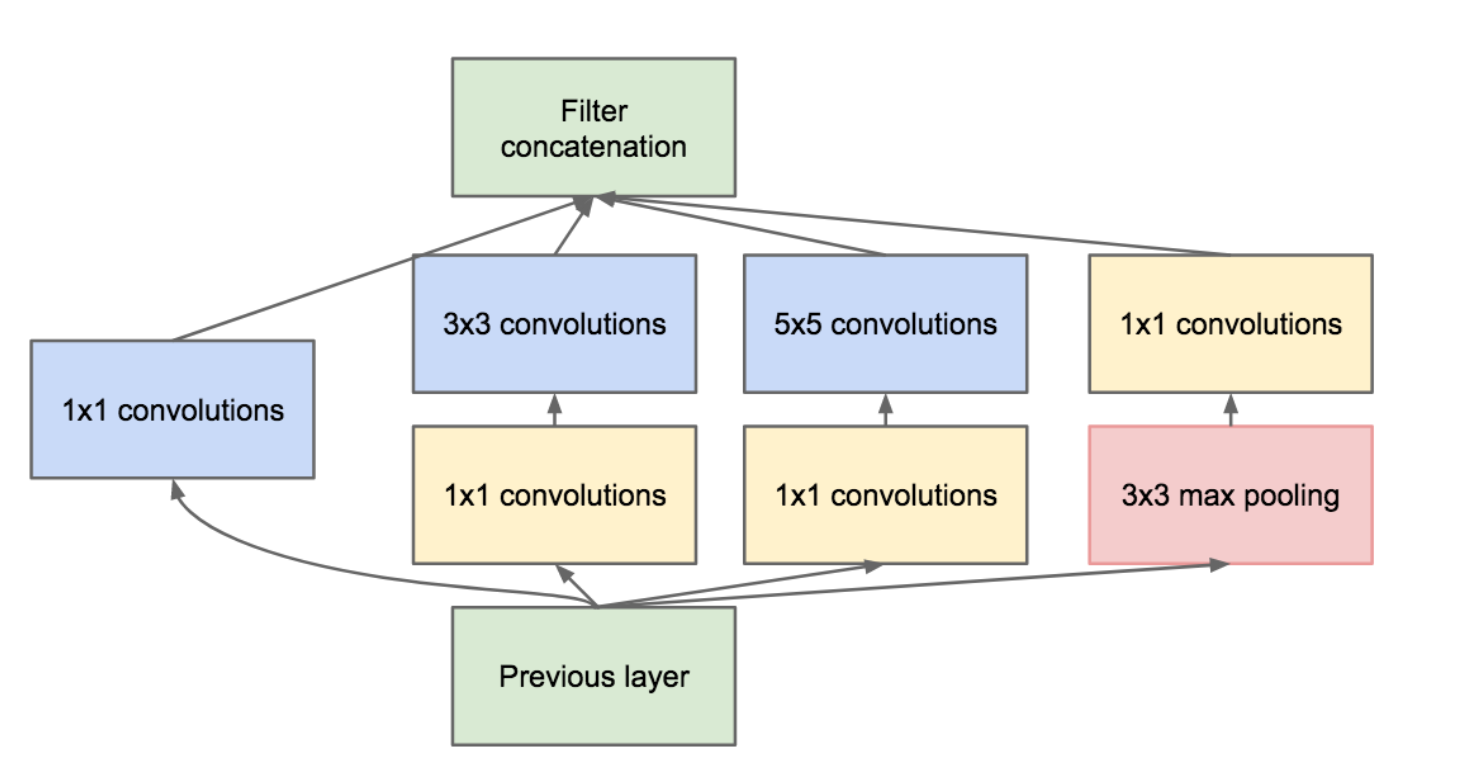

TL;DR:
- use at the same level multiple convolutions with different kernels size
- each capture information at different scales
- to avoid prohibitive computational cost, 1x1 convolutions (in yellow) are used to reduce dimensions in the channel axis
- in practice those inception blocks can be slightly different depending on their position in the network, but we will skip that part for now
- also added a cross-entropy loss at multiple levels of the network in order to train deep CNN

Implement this block. Note that the 1x1 convolution of the 3x3 and 5x5 branches will produce a `reduced_channels` amount of channels to avoid using too much parameters.

In [ ]:
class InceptionBlock(nn.Module):
  def __init__(self, in_channels, reduced_channels, out_channels):
    super().__init__()

    # TODO

  def forward(self, x):
    # TODO
    return x


InceptionBlock(32, 16, 64)(torch.randn(1, 32, 32, 32)).shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/cnn/inception.py
%pycat inception.py

Full implementation here https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py, but don't look before trying!

## 2. ResNet

📋 [Paper link](https://arxiv.org/abs/1512.03385)

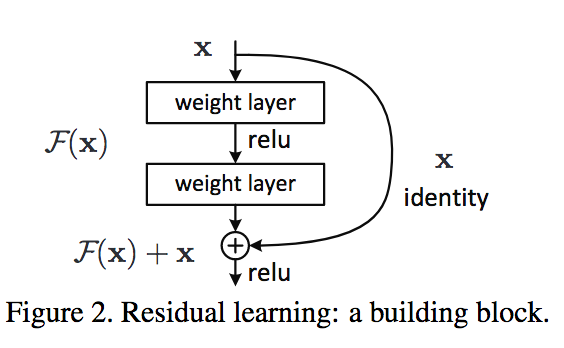




TL;DR:

- shortcut allows learning very deep networks (up to thousands of layers!) without the vanishing gradient at the network start
- intuitively, the network learns minimal modifications (link to [minimal transport](https://hal.archives-ouvertes.fr/hal-03038615/document) of the image
- this residual trick is MAJOR and can be found in pretty much all modern architectures, and not only for computer vision!

Many variations of this residual block exists, but for now, code this basic version. Note that the spatial dimension after the two weight layers (convs) must be left unchanged so that identity can be done. 

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, input_channels, hidden_channels):
    super().__init__()
    # Use a kernel size of 3

    # TODO

  def forward(self, x):
    # TODO

    return x


ResBlock(16, 8)(torch.randn(2, 16, 32, 32)).shape

In [ ]:
# Execute this cell to see the solution, but try to do it by yourself before!
!wget https://raw.githubusercontent.com/arthurdouillard/deepcourse/master/static/code/cnn/res.py
%pycat res.py

Full implementation here https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py, but don't look before trying!*italicized text*

# Further

There are plenty of CNN architectures that we didn't cover. A good exercise is to read the papers, implement them, and try to run them on a small dataset like CIFAR.

Here is a non-exhaustive list:
- MobileNet: https://arxiv.org/abs/1704.04861
- ShuffleNet: https://arxiv.org/abs/1707.01083
- SEnet: https://arxiv.org/abs/1709.01507
- DenseNet: https://arxiv.org/abs/1608.06993
- ResNext: https://arxiv.org/abs/1611.05431
- EfficientNet: https://arxiv.org/abs/1905.11946

